En este código se busca mostrar como un fluido modelado mediante la ecuación de Navier-Stokes cumple con el principio de Bernoulli.

In [2]:
# importar gmsh

%%capture
try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

In [3]:
# importar dolfinx

%%capture
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [4]:
# instalar e importar pyvista

!pip install pyvista
import pyvista as pv

In [5]:
!pip install PyVirtualDisplay

In [6]:
from dolfinx import  default_scalar_type

In [7]:
import pyvista as pv
from pyvirtualdisplay import Display
from dolfinx.plot import vtk_mesh

display = Display(visible=0, size=(600, 400))
display.start()

pv.OFF_SCREEN=False
pv.set_jupyter_backend("static")
pv.plotting.close_all()

True

In [8]:
# gmsh
import gmsh

# ufl
import ufl

# MPI
from mpi4py import MPI

# dolfinx
import dolfinx.fem.petsc
from dolfinx.io import XDMFFile, distribute_entity_data, gmshio
from dolfinx import io, cpp, fem, mesh, plot

# PETSc
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType, Mat

# SLEPc
from slepc4py import SLEPc

# numpy
import numpy as np

# pyplot
import matplotlib.pyplot as plt
from matplotlib import cm

# time
import time

# imageio
import imageio

In [9]:
# comm
comm = MPI.COMM_WORLD

El dominio que se utilizará consiste de dos zonas rectangulares de distinta altura, la de mayor altura se une a la de menor altura por el extremo izquierdo. Los vértices son los siguientes:

In [38]:
vertices = [[0.0,0.0],[0.0,1.0],[1.0/3,1.0],[2.0/3,2.0/3],[4.0/3,2.0/3],[4.0/3,1.0/3],[2.0/3,1.0/3],[1.0/3,0.0]]

Se utiliza gmsh para realizar el modelo y el mallado de esta figura:

In [39]:

def create_dom2d_polygon(points, min_size=0.03, max_size=0.05):
    """
    Crea un polígono 2D a partir de una lista de puntos y genera la malla.

    Parameters:
    points (list of list): Lista de coordenadas (x, y) para los vértices del polígono.
    min_size (float): Tamaño mínimo de la malla en el área de refinamiento.
    max_size (float): Tamaño máximo de la malla fuera del área de refinamiento.

    Returns:
    domain: Dominio de la malla creado con dolfinx.
    mesh_comm: Comunicador MPI utilizado para la malla.
    """
    gmsh.initialize()
    gmsh.model.add("polygon")

    # Crear puntos en Gmsh
    point_tags = [gmsh.model.occ.addPoint(x, y, 0) for x, y in points]

    # Crear líneas entre los puntos para formar el polígono
    line_tags = []
    num_points = len(points)
    for i in range(num_points):
        line_tags.append(gmsh.model.occ.addLine(point_tags[i], point_tags[(i + 1) % num_points]))

    # Crear la curva cerrada y la superficie
    curve_loop = gmsh.model.occ.addCurveLoop(line_tags)
    surface = gmsh.model.occ.addPlaneSurface([curve_loop])

    # Sincronizar las operaciones para aplicar cambios
    gmsh.model.occ.synchronize()

    # Crear un grupo físico para el polígono
    gmsh.model.addPhysicalGroup(2, [surface], tag=1)

    # Definir un campo para el refinamiento de la malla
    field_tag1 = gmsh.model.mesh.field.add("Box")
    gmsh.model.mesh.field.setNumber(field_tag1, "VIn", min_size)
    gmsh.model.mesh.field.setNumber(field_tag1, "VOut", max_size)

    # Definir un bounding box que abarque todo el polígono
    x_coords, y_coords = zip(*points)
    gmsh.model.mesh.field.setNumber(field_tag1, "XMin", min(x_coords))
    gmsh.model.mesh.field.setNumber(field_tag1, "XMax", max(x_coords))
    gmsh.model.mesh.field.setNumber(field_tag1, "YMin", min(y_coords))
    gmsh.model.mesh.field.setNumber(field_tag1, "YMax", max(y_coords))
    gmsh.model.mesh.field.setNumber(field_tag1, "Thickness", 0.1)

    # Establecer el campo como la malla de fondo
    gmsh.model.mesh.field.setAsBackgroundMesh(field_tag1)

    # Generar la malla en 2D
    gmsh.model.mesh.generate(2)

    # Exportar la malla a dolfinx
    gmsh_model_rank = 0
    mesh_comm = MPI.COMM_WORLD
    domain, cell_markers, facet_markers = gmshio.model_to_mesh(model=gmsh.model, comm=mesh_comm, rank=gmsh_model_rank, gdim=2)

    domain.topology.create_connectivity(domain.topology.dim, 0)
    domain.topology.create_connectivity(0, domain.topology.dim)

    gmsh.finalize()

    return domain, mesh_comm


# Crear el polígono y generar la malla
polygon, mesh_comm = create_dom2d_polygon(vertices)

with io.XDMFFile(mesh_comm,'polygon.xdmf','w') as xmdf:
  xmdf.write_mesh(polygon)


encoding=XDMFFile.Encoding.HDF5

Aquí se puede apreciar graficamente el polígono generado:

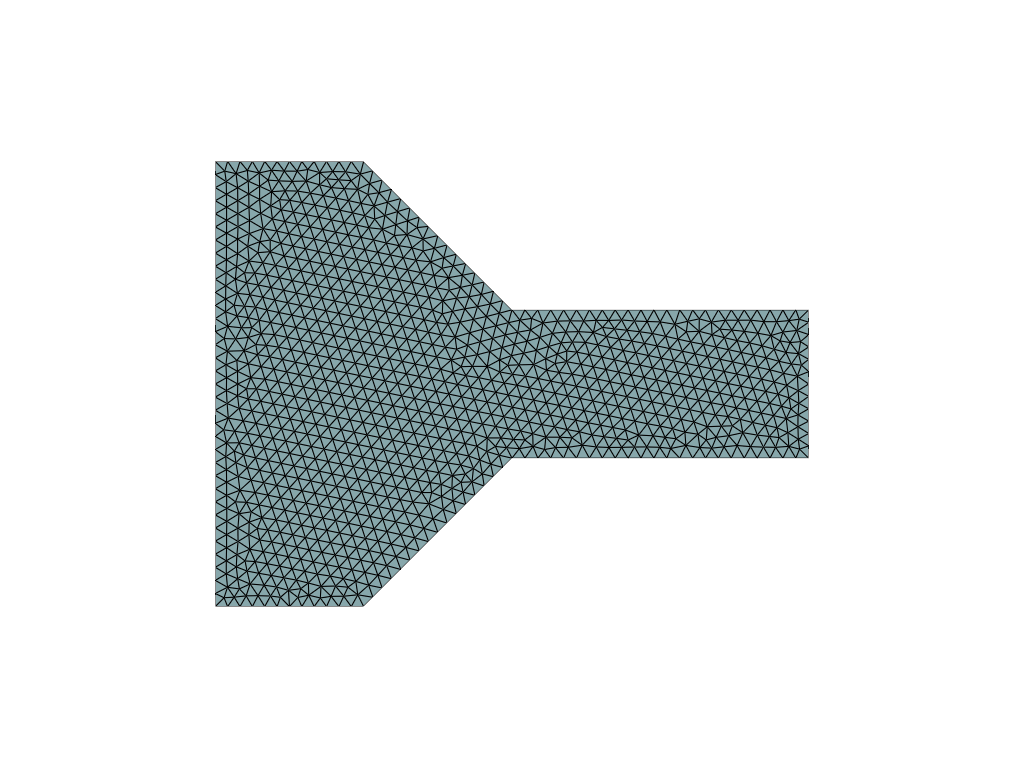

In [40]:
# Cargar el archivo XDMF
polygon_plot = pv.read('polygon.xdmf')

# Crear un plotter y visualizar la malla
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(polygon_plot, show_edges=True)
plotter.view_xy()
plotter.show()

Tras esto se definirán las condiciones de borde y el método principal para resolver la ecuación de Navier Stokes mediante elementos finitos y el método de Chorin para resolver Navier Stokes:

In [43]:
# Definir funciones que identifican las facetas en el borde
def on_top(x, y_max=1.0):
    return np.isclose(x[1], y_max)

y_max1 = 2.0/3
def on_top2(x,y_max = y_max1):
    return np.isclose(x[1], y_max)

def on_bottom(x, y_min=0.0):
    return np.isclose(x[1], y_min)

y_min1 = 1.0/3
def on_bottom2(x,y_min1 = y_min1):
  return np.isclose(x[1],y_min1)

def on_left(x, x_min=0.0):
    return np.isclose(x[0], x_min)

x_max = 4.0/3
def on_right(x, x_max=x_max):
    return np.isclose(x[0], x_max)

def diagonal(x):
    return np.isclose(x[0] + x[1], 1.0)

In [44]:

def solvebernoulli(domain: mesh.Mesh, Vspace: fem.FunctionSpace, Qspace: fem.FunctionSpace,
          uprev: fem.Function, pprev: fem.Function, deltat: float, nu: float, f:fem.Function) -> tuple:
    U = ufl.TrialFunction(Vspace)
    v = ufl.TestFunction(Vspace)

    tdim = domain.topology.dim
    fdim = tdim - 1

    domain.topology.create_connectivity(fdim, tdim)
    boundary_facets = mesh.exterior_facet_indices(domain.topology)

    bcleft_dofs = fem.locate_dofs_geometrical(Vspace, on_left)
    bctop_dofs = fem.locate_dofs_geometrical(Vspace, on_top)
    bcbut_dofs = fem.locate_dofs_geometrical(Vspace, on_bottom)
    bctop2_dofs = fem.locate_dofs_geometrical(Vspace, on_top2)
    bcbut2_dofs = fem.locate_dofs_geometrical(Vspace, on_bottom2)
    bcdiagon_dofs = fem.locate_dofs_geometrical(Vspace, diagonal)

    bcright_dofs = fem.locate_dofs_geometrical(Qspace, on_right)

    bcleft = fem.dirichletbc(PETSc.ScalarType((0.1, 0)), bcleft_dofs, Vspace)
    bctop = fem.dirichletbc(PETSc.ScalarType((0, 0)), bctop_dofs, Vspace)
    bcbut = fem.dirichletbc(PETSc.ScalarType((0, 0)), bcbut_dofs, Vspace)
    bctop2 = fem.dirichletbc(PETSc.ScalarType((0, 0)), bctop2_dofs, Vspace)
    bcbut2 = fem.dirichletbc(PETSc.ScalarType((0, 0)), bcbut2_dofs, Vspace)
    bcdiagon = fem.dirichletbc(PETSc.ScalarType((0, 0)), bcdiagon_dofs, Vspace)


    bcrightp = fem.dirichletbc(fem.Constant(domain, ScalarType((0))) , bcright_dofs, Qspace)
    F1 = (ufl.inner((U - uprev) / deltat, v) +
          ufl.inner(ufl.dot(ufl.grad(uprev), uprev), v) +
          nu * ufl.inner(ufl.grad(U), ufl.grad(v)) -
          ufl.inner(f, v)) * ufl.dx
    a1, L1 = ufl.lhs(F1), ufl.rhs(F1)

    problem1 = fem.petsc.LinearProblem(a1, L1, bcs=[bcleft, bctop, bcbut, bcdiagon,bctop2,bcbut2])
    uh_star = problem1.solve()

    p = ufl.TrialFunction(Qspace)
    q = ufl.TestFunction(Qspace)
    a2 = ufl.inner(ufl.grad(p), ufl.grad(q)) * ufl.dx
    L2 = - (1 / deltat) * ufl.inner(ufl.div(uh_star), q) * ufl.dx

    problem2 = fem.petsc.LinearProblem(a2, L2, bcs = [bcrightp])#quite las bc
    ph = problem2.solve()

    U_ = ufl.TrialFunction(Vspace)
    v_ = ufl.TestFunction(Vspace)

    F3 = (ufl.inner(U_, v_) -
          ufl.inner(uh_star, v_) +
          deltat * ufl.inner(ufl.grad(ph), v_)) * ufl.dx
    a3, L3 = ufl.lhs(F3), ufl.rhs(F3)

    problem3 = fem.petsc.LinearProblem(a3, L3, bcs=[bcleft, bctop, bcbut, bcdiagon,bctop2,bcbut2])
    uh = problem3.solve()

    return uh, ph

In [45]:
Vspace = fem.functionspace(polygon, ("Lagrange", 1, (2,)))
Qspace = fem.functionspace(polygon, ("Lagrange", 1))
pprev = fem.Constant(polygon, ScalarType((0)))
uprev = fem.Constant(polygon, ScalarType((0,0)))

deltat = 0.2
nu = 0.05
f = fem.Constant(polygon, ScalarType((0,0)))
uh2, ph2 = solvebernoulli(polygon, Vspace, Qspace, uprev, pprev, deltat, nu,f)

Con esto se puede graficar la primera iteración del método, su velocidad y su presión:

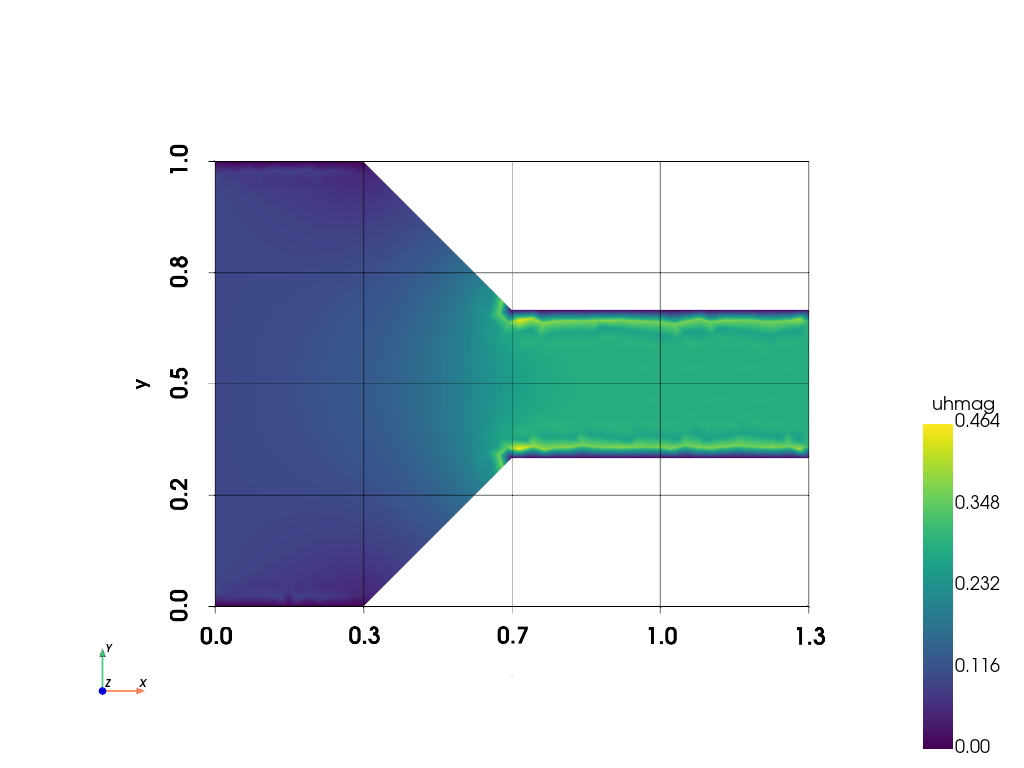

In [46]:
uh = uh2[1]
connectivity = polygon.topology.connectivity(polygon.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = polygon.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid = pv.UnstructuredGrid(cells, cell_types, x)
grid.point_data["uhmag"] = np.linalg.norm(uh2.x.array.reshape(-1,2), axis = 1)
grid.set_active_scalars("uhmag")

plotter.add_mesh(grid, cmap = "viridis", lighting = False, scalars = "uhmag", show_edges = False, show_scalar_bar = True, scalar_bar_args = {"vertical": True})
plotter.view_xy()
plotter.show_axes()
plotter.show_grid(xtitle = "x", ytitle = "y")

plotter.show()

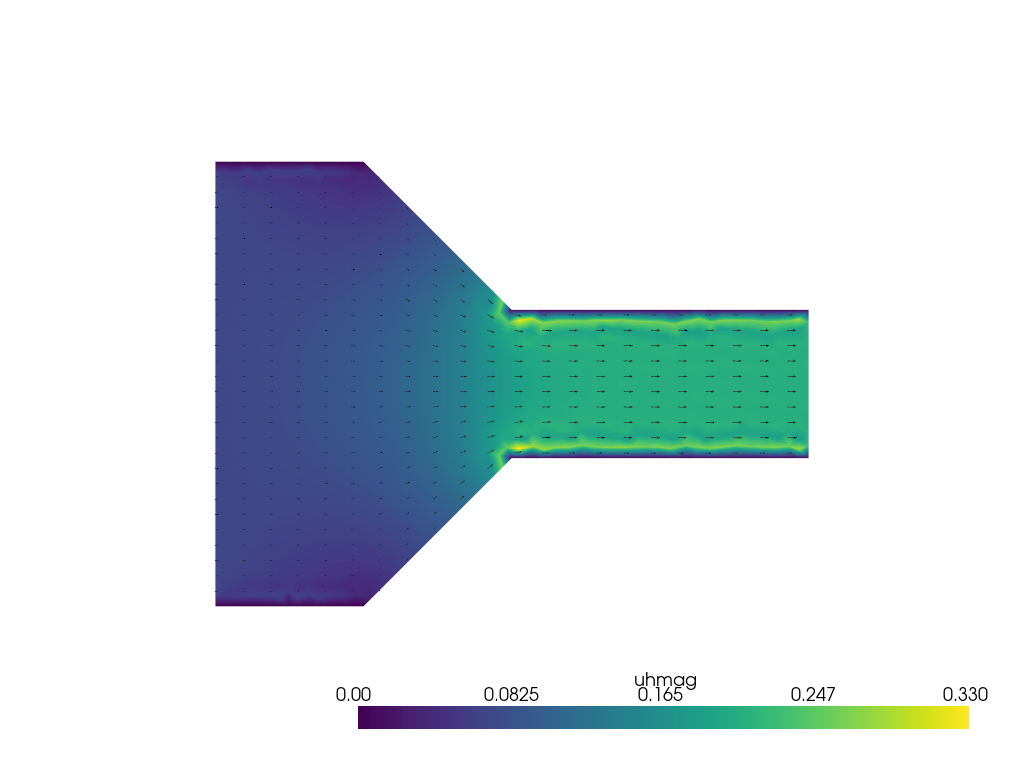

In [47]:
subplotter = pv.Plotter(shape = (1,1), notebook = True)

grid.point_data["uh2"] = np.vstack((uh2.x.array.reshape(-1,2)[:,0],
                                   uh2.x.array.reshape(-1,2)[:,1],
                                   np.zeros_like(uh2.x.array.reshape(-1,2)[:,0]))).T # agregar vector de uh


grid.set_active_scalars("uhmag") # activar magnitud de dw como escalar para graficar
grid.set_active_vectors("uh2") # activar dw como vectores para graficar

Lx=3
Ly=1
nx_new=50
ny_new=30
xx, yy = np.meshgrid(np.linspace(0, Lx, nx_new), np.linspace(0, Ly, ny_new))
points = np.column_stack((xx.flatten(), yy.flatten(), np.zeros(nx_new*ny_new)))
sample_grid = pv.StructuredGrid(xx, yy, np.zeros_like(xx))
resampled_grid = sample_grid.sample(pass_point_data = True, target = grid)


glyphs = resampled_grid.glyph(orient = "uh2", factor = 0.07) # crear glyph (flechas en direcciones)

subplotter.subplot(0,0)
subplotter.add_mesh(grid, cmap = "viridis", lighting = False, show_scalar_bar=False)
subplotter.add_mesh(glyphs, cmap = "viridis", scalars = "uhmag", lighting = False, show_scalar_bar=True, show_edges=True)
subplotter.view_xy() # mismo gráfico, pero en plano xy

subplotter.show()

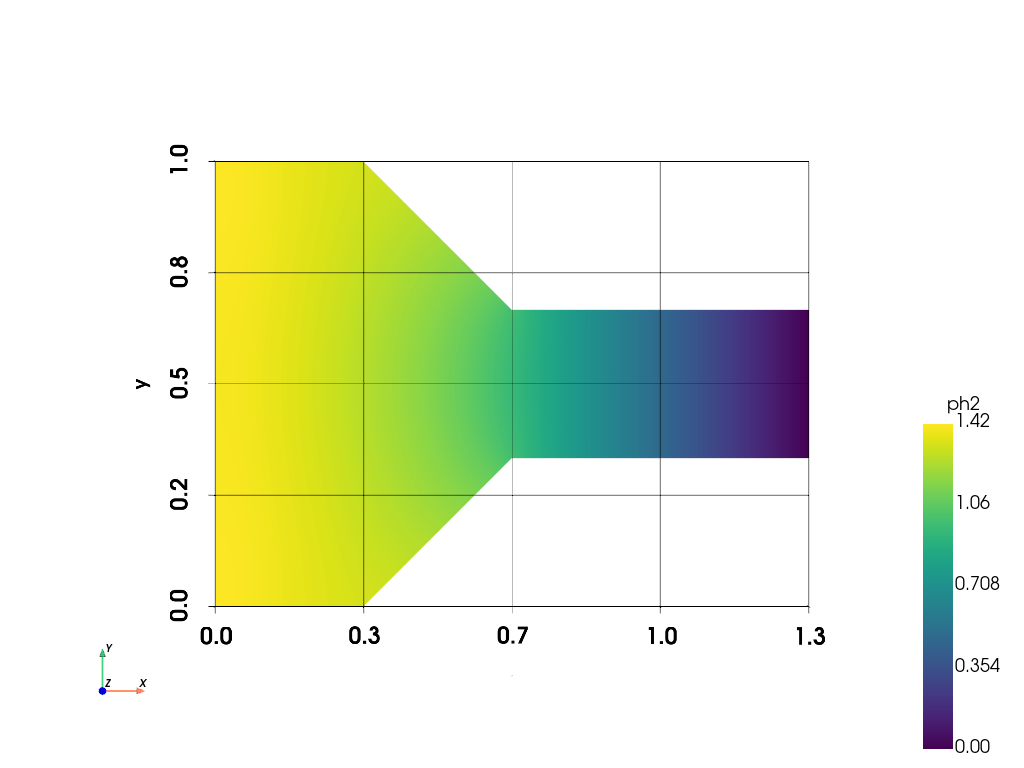

In [48]:
connectivity = polygon.topology.connectivity(polygon.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = polygon.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid = pv.UnstructuredGrid(cells, cell_types, x)
grid.point_data["ph2"] = ph2.x.array
grid.set_active_scalars("ph2")

plotter.add_mesh(grid, cmap = "viridis", lighting = False, scalars = "ph2", show_edges = False, show_scalar_bar = True, scalar_bar_args = {"vertical": True})
plotter.view_xy()
plotter.show_axes()
plotter.show_grid(xtitle = "x", ytitle = "y")

plotter.show()

Finalmente sigue la implementación de las iteraciones mediante diferencias finitas para realizar la simulación completa.

In [49]:
def supersolvebernoulli(domain: mesh.Mesh, Vspace: fem.FunctionSpace, Qspace: fem.FunctionSpace,
          uprev: fem.Function, pprev: fem.Function, deltat: float, nu: float, f:fem.Function, T:float) -> tuple:
          start_time = time.time()
          t = deltat
          upr = uprev
          ppr = pprev
          uH = [uprev]
          pH = [pprev]
          while t<T+10**(-5):
            if np.isclose(t,1.0, atol=1e-04):
              end_time = time.time()
              time_aprox = (end_time - start_time)*T
              min_aprox = time_aprox // 60
              print("Tiempo aprox: "+ str(round(min_aprox // 60)) + " horas y " + str(round(min_aprox % 60))+ " minutos.")
            if np.isclose(t%1,0.0,atol=1e-04) or np.isclose(t%1,1,atol=1e-04):
              print("t: " + str(round(t,1)))
            uh, ph = solvebernoulli(domain, Vspace, Qspace, upr, ppr, deltat, nu,f)
            uH.append(uh)
            pH.append(ph)
            upr = uh
            ppr = ph
            t+=deltat
          return uH,pH

In [50]:
domain = polygon

Vspace = fem.functionspace(domain, ("Lagrange", 1, (2,)))
Qspace = fem.functionspace(domain, ("Lagrange", 1))
pprev = fem.Constant(domain, ScalarType((0)))
uprev = fem.Constant(domain, ScalarType((0,0)))


deltat = 0.025
nu = 0.01
f = fem.Constant(domain, ScalarType((0,0)))
uH, pH = supersolvebernoulli(domain, Vspace, Qspace, uprev, pprev, deltat, nu,f,10)

Tiempo aprox: 0 horas y 0 minutos.
t: 1.0
t: 2.0
t: 3.0
t: 4.0
t: 5.0
t: 6.0
t: 7.0
t: 8.0
t: 9.0
t: 10.0


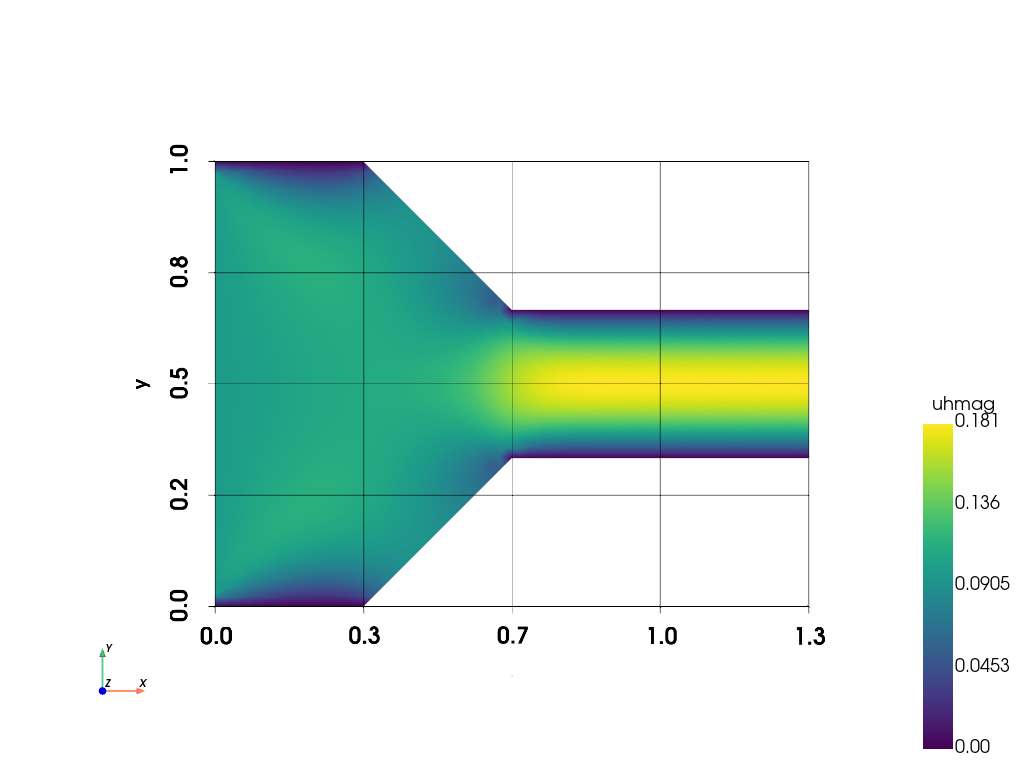

In [51]:
uh = uH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid = pv.UnstructuredGrid(cells, cell_types, x)
grid.point_data["uhmag"] = np.linalg.norm(uh.x.array.reshape(-1,2), axis = 1)
grid.set_active_scalars("uhmag")

plotter.add_mesh(grid, cmap = "viridis", lighting = False, scalars = "uhmag", show_edges = False, show_scalar_bar = True, scalar_bar_args = {"vertical": True})
plotter.view_xy()
plotter.show_axes()
plotter.show_grid(xtitle = "x", ytitle = "y")

plotter.show()

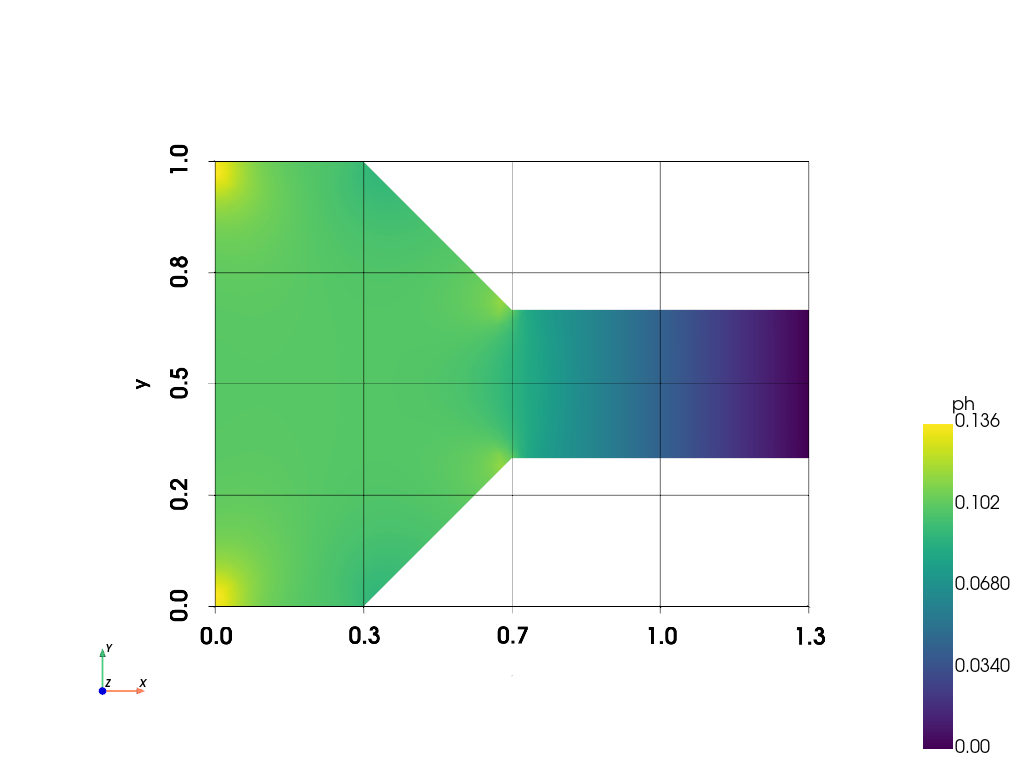

In [52]:
ph = pH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid = pv.UnstructuredGrid(cells, cell_types, x)
grid.point_data["ph"] = ph.x.array
grid.set_active_scalars("ph")

plotter.add_mesh(grid, cmap = "viridis", lighting = False, scalars = "ph", show_edges = False, show_scalar_bar = True, scalar_bar_args = {"vertical": True})
plotter.view_xy()
plotter.show_axes()
plotter.show_grid(xtitle = "x", ytitle = "y")

plotter.show()

De los gráficos extraídos se puede recalcar como el fluido muestra el comportamiento esperado pues cumple con el principio de Bernoulli que expresa que en las zonas con una mayor área (para el caso en 2 dimensiones) debe haber mayor presión y menor velocidad en tanto que, en zonas con menor área, la velocidad aumenta y la presión disminuye.